In [1]:
from games import Env2048

import time
import random
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from IPython.display import clear_output

Initial policy -> Random
Evaluate/update action value function using each action in initial policy

Argmax over action-values to get updated policy
Evaluate/update action value function with next policy


Value iteration until convergence if model is known. Don't need to know intermediate policies
Async value iteration avoids having 2 copies of state space

In [2]:
class DQN(nn.Module):
    def __init__(self, height, width, n_actions):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=height * width, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=128)
        self.out = nn.Linear(in_features=128, out_features=n_actions)
        
    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        # TODO: output > 0/ as prob
        return t

# TODO: CNN feature mappings
class DQCNN(nn.Module):

    def __init__(self, height, width, n_actions):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.out = nn.Linear(64 * height * width, n_actions)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.out(x.view(x.size(0), -1)) # flatten
        return x


Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward', 'done')
)

class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
    
    def append(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    
#     def __repr__(self):

In [3]:
# TODO: Agent interface to interact with GUI
class DQNAgent():
    def __init__(self, weights, hyperparams):
        pass
    
    def train(self):
        with torch.no_grad():
            pass
        pass
    
    def get_move(self) -> int:
        # DQN pred action-value
        # filter to valid moves
        # DQN best action-value
        pass
# Add to class as helper
action_map = {
    0: 'LEFT',
    1: 'UP',
    2: 'RIGHT',
    3: 'DOWN',
}

In [4]:
def unpack_batch(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))

    batch_states = torch.cat(batch.state)
    batch_actions = torch.cat(batch.action)
    batch_next_states = torch.cat(batch.next_state)
    batch_rewards = torch.cat(batch.reward)
    batch_done = torch.cat(batch.done)

    return batch_states, batch_actions, batch_next_states, batch_rewards, batch_done

In [5]:
# Hyperparams
BATCH_SIZE = 128
MEMORY_SIZE = 10000
GAMMA = 0.99
EPS = 0.05
TARGET_UPDATE = 10
MA_WINDOW = 100

# TODO: Use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = Env2048()

rewards_window = deque(maxlen=MA_WINDOW)
memory = ReplayMemory(MEMORY_SIZE)
loss_fn = nn.MSELoss() # f(inp, target)
policy_net = DQN(env.height, env.width, env.action_space.n).to(device)
target_net = DQN(env.height, env.width, env.action_space.n).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters()) # Maybe customize lr

Episode 299
100 episode reward moving avg: -118.76000213623047
Max tile 128
[[  2   8   4   2]
 [  8 128   8   4]
 [ 32  16  64   8]
 [  2   4   8   4]]


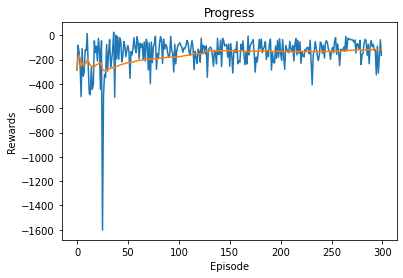

In [6]:
NUM_EPISODES = 300
episode_rewards = torch.zeros(NUM_EPISODES)
moving_avg_rewards = torch.zeros(NUM_EPISODES)
max_tiles = torch.zeros(NUM_EPISODES)
for episode in range(NUM_EPISODES):
    env.reset()
    done = False
    curr_state = torch.Tensor(env.grid.copy()).unsqueeze(0)
    
    rng = np.random.default_rng(seed=None)
    episode_reward = torch.tensor([0])
    while not done:
        
#         # Random
#         out = torch.rand((1, env.action_space.n))
# #         out[:, env.get_invalid_moves()] = 0
#         action = out.argmax(dim=1)
#         next_state, reward, done, info = env.step(action.item())
#         next_state = torch.Tensor(next_state).unsqueeze(0)
#         episode_reward += reward
#         reward = torch.tensor(reward).unsqueeze(0)
#         memory.append(Experience(curr_state, action, next_state, reward, torch.tensor(done).unsqueeze(0)))
#         curr_state = next_state
        
        
        # DQN
        # Select action and get next state
        with torch.no_grad():
            if EPS > rng.random():
                out = torch.rand((1, env.action_space.n)) # explore
            else:
                out = policy_net(curr_state) # exploit
            # Filter valid actions

            # out[:, env.get_invalid_moves()] = 0
        action = out.argmax(dim=1)
        next_state, reward, done, info = env.step(action.item())
        next_state = torch.Tensor(next_state).unsqueeze(0)
        episode_reward += reward
        reward = torch.tensor(reward).unsqueeze(0)
        memory.append(Experience(curr_state, action, next_state, reward, torch.tensor(done).unsqueeze(0)))
        curr_state = next_state
        
        # Start training once min samples reach
        if len(memory) >= BATCH_SIZE:
            experience_batch = memory.sample(BATCH_SIZE)
            batch_states, batch_actions, batch_next_states, batch_rewards, batch_done = unpack_batch(experience_batch)
            
            current_Q = policy_net(batch_states).gather(dim=1, index=batch_actions.unsqueeze(-1))
            next_Q, max_indexes = target_net(batch_next_states).max(dim=1)
            # If lose game, all action-values are 0
            next_Q[batch_done] = 0
            target_Q = (next_Q * GAMMA) + batch_rewards

            loss = loss_fn(current_Q, target_Q)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    
    # Track progress
    max_tile = np.max(env.grid)
    max_tiles[episode] = max_tile
    episode_rewards[episode] = (episode_reward)
    rewards_window.append(episode_reward)
    moving_avg_rewards[episode] = np.mean(rewards_window)
    # Plot rewards
    clear_output(wait=True)
#     plt.clf()
#     plt.title('Training...')
#     plt.xlabel('Episode')
#     plt.ylabel('Rewards')
#     plt.plot(episode_rewards)
#     plt.plot(moving_avg_rewards)
#     plt.pause(0.0001)
    print("Episode", episode)
    print(len(rewards_window), "episode reward moving avg:", moving_avg_rewards[episode].item())
    print("Max tile", max_tile)
    env.render()
    
    # Update target network every certain episodes
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

plt.clf()
plt.title('Progress')
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.plot(episode_rewards)
plt.plot(moving_avg_rewards);

# plt.plot(np.log2(max_tiles)[:100])
# # or
# plt.plot(max_tiles[-100:])
# plt.yscale('log', base=2)
# env.close()

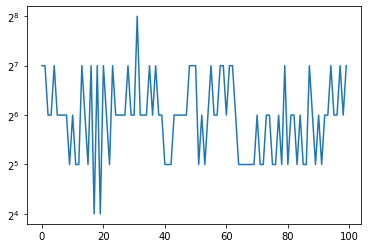

tensor(78.4000)
tensor(71.6800)


In [7]:
plt.plot(max_tiles[-100:])
plt.yscale('log', base=2)
plt.show()
print(max_tiles[:100].mean())
print(max_tiles[-100:].mean())

Reward
1 for valid move;
0 for end game;
-1 for invalid move;

Up to few hundred epoch - learns to die rather than make invalid move

Probably have to train much more to learn valid moves

## Execute sample agent

In [8]:
env = Env2048()
env.reset()
env.render()
done = False

rng = np.random.default_rng(seed=None)
while not done:
    with torch.no_grad():
        out = policy_net(curr_state) # exploit
        # Filter valid actions, set to low q-value, take best valid move
        out[:, env.get_invalid_moves()] = -1e6
    
        action = out.argmax(dim=1).item()
    next_state, reward, done, info = env.step(action)
    
    clear_output(wait=True)
    print(action_map[action])
    env.render()
    time.sleep(0.2)

print("Max tile:", np.max(env.grid))

DOWN
[[  4  16   4   2]
 [  8  32   8   4]
 [ 32   8  16   8]
 [128  16   2  16]]
Max tile: 128
